In [ ]:
# @title Introduction
# @markdown In this coding exercise, we explore the effectiveness of Evolution Strategies (ES) and Genetic Algorithms (GA) using the BlackBox Optimization Benchmarking ([BBOB](https://numbbo.github.io/coco/testsuites/bbob)) test suite as our set of target functions.
# @markdown Our objective is to demonstrate how these algorithms operate and optimize solutions in a controlled setting.

# @markdown To facilitate a clear understanding and enable effective visualization, all implementations of the ES/GA algorithms will be executed using only NumPy, focusing on two-dimensional (2D) target functions.
# @markdown This dimensionality constraint allows us to visually illustrate the optimization process and the algorithms' performance on these functions.


# Numpy is all you need ;)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

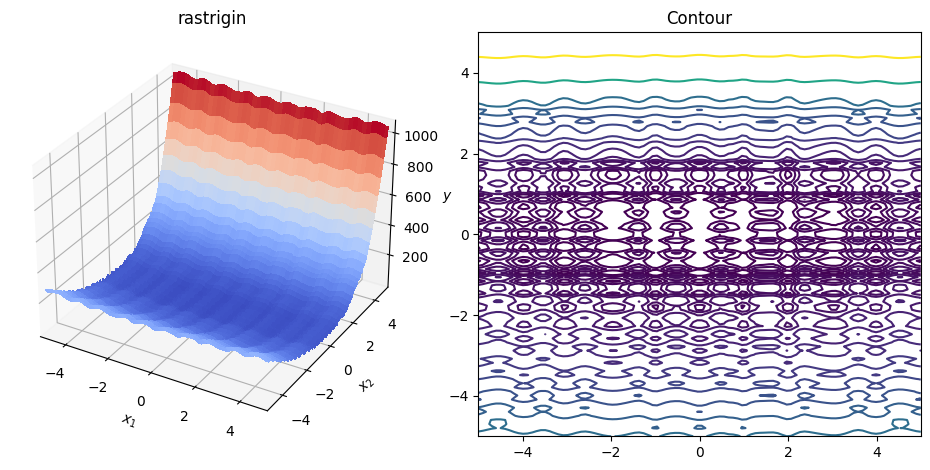

In [ ]:
# @title Defining target functions { run: "auto" }
# @markdown Let's first define some target functions, feel free to add more. \\

# === Utility Functions ===

def lambda_alpha(x, alpha):
    dim = x.shape[-1]
    diag = np.power(alpha, 0.5 * np.arange(dim) / (dim - 1))
    return np.diag(diag)


def f_pen(x):
    return np.sum(np.square(np.maximum(0, np.abs(x) - 5)), axis=-1)


def t_osz(x):
    x_hat = np.where(x != 0, np.log(np.abs(x)), 0)
    c1 = np.where(x > 0, 10., 5.5)
    c2 = np.where(x > 0, 7.9, 3.1)
    return np.sign(x) * np.exp(x_hat + 0.049 * (np.sin(c1 * x_hat) +
                                                np.sin(c2 * x_hat)))


def t_asy(x, beta):
    dim = x.shape[-1]
    tmp = x.copy()
    tmp[tmp < 0] = 1
    power = np.where(
        x > 0, 1 + beta * np.arange(dim) / (dim - 1) * np.sqrt(tmp), 1)
    return np.power(x, power)


# === BBO Functions ===

def sphere_fn(x):
    z = x
    return np.sum(np.square(z), axis=-1)


def separable_ellipsoidal_fn(x):
    dim = x.shape[-1]
    z = t_osz(x)
    term1 = np.power(10, 6 * np.arange(dim) / (dim - 1))[None, ...]
    term2 = np.square(z)
    return np.sum(term1 * term2, axis=-1)


def rastrgin_fn(x):
    dim = x.shape[-1]
    z = np.dot(t_asy(t_osz(x), 0.2), lambda_alpha(x, 10))
    term1 = 10 * (dim - np.sum(np.cos(2 * np.pi * z), axis=-1))
    term2 = np.sum(np.square(z), axis=-1)
    return term1 + term2


def buche_rastrigin_fn(x):
    dim = x.shape[-1]
    cond = np.logical_and((np.arange(dim) % 2 == 0)[None, ...], x > 0)
    s = np.power(10, 0.5 * np.arange(dim) / (dim - 1))
    s = np.where(cond, 10 * s[None, ...], s[None, ...])
    z = s * t_osz(x)
    term1 = 10 * np.sum(dim - np.cos(2 * np.pi * z), axis=-1)
    term2 = np.sum(np.square(z), axis=-1)
    term3 = 100 * f_pen(x)
    return term1 + term2 + term3


# == Plotting Utility ===

def plot_fn(name, fn, traj=None,
            x_min=-5, x_max=5, num_levels=15, num_points_per_dim=100):
    x = np.linspace(x_min, x_max, num_points_per_dim)
    x1, x2 = np.meshgrid(x, x)
    x = np.stack([x1, x2]).reshape(2, -1).T
    y = fn(x).reshape(num_points_per_dim, num_points_per_dim)

    fig = plt.figure(figsize=plt.figaspect(.5))

    # Plot the function.
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.plot_surface(x1, x2, y, cmap='coolwarm', linewidth=0, antialiased=False)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$y$")
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])
    ax.set_title(name.replace("_", " "))

    # Plot the contour.
    ax = fig.add_subplot(1, 2, 2)
    quantiles = (np.arange(num_levels + 2) / (num_levels + 1))[1:-1]
    ax.contour(x1, x2, y, np.quantile(y, quantiles))
    title = "Contour"
    if traj is not None:
        traj_len = traj.shape[0]
        alphas = np.linspace(0.1, 1, traj_len)
        for i in range(traj_len):
            ax.scatter(traj[i, 0], traj[i, 1],
                       color='black', marker="o", s=100, alpha=alphas[i])
        title += " & Optimization Trajectory"
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])
    ax.set_title(title)

    plt.tight_layout()


# === Main ===

fn_name = "rastrigin" # @param ["sphere", "separable_ellipsoidal", "rastrigin", "buche-rastrigin"] {allow-input: false}
name_fn_dict = {
    "sphere": sphere_fn,
    "separable_ellipsoidal": separable_ellipsoidal_fn,
    "rastrigin": rastrgin_fn,
    "buche-rastrigin": buche_rastrigin_fn,
}
target_fn = name_fn_dict[fn_name]
plot_fn(fn_name, target_fn)

In [ ]:
# @title Introducing *ask()* \& *tell()*
# @markdown It is beneficial to write our ES/GA algorithms that conform to a unified set of interfaces. \\
# @markdown In this exercise, we are going to use the conventional `ask()` and `tell()` that are adopted by most ES/GA libraries. \\
# @markdown Please expand the code in this cell and get familiar with the `BaseAlgo` interface.

from typing import List, Union


class BaseAlgo(object):
    """Interface definition for all ES/GA algorithms."""

    pop_size: int       # Size of the population.
    num_params: int     # num_params=2 here because target functions are in 2D.

    def ask(self) -> np.ndarray:
        """Return a population of solutions for the next generation.

        Returns:
          An array of size (pop_size, num_params).
        """
        raise NotImplementedError()

    def tell(self, fitness: Union[np.ndarray, List]) -> None:
        """Update the internal state based on the fitness scores.

        Arguments:
          fitness - An array of size pop_size, representing the fitness score
                    for each of the individual in the population.
        """
        raise NotImplementedError()

In [ ]:
# @title See how CMA-ES works
# @markdown [CMA-ES](https://arxiv.org/abs/1604.00772) is a popular and powerful ES algorithm, and is conveniently provided as a python package. \\
# @markdown Although the package provides rich interfaces for various user demands, we show how the target functions can be optimized through its `ask()` and `tell()` calls. Feel free to play with the following parameters. \\
# @markdown The optimization trajectory is plotted on the contour map, with recent points in darker colors.

try:
    import cma
except ModuleNotFoundError:
    !pip install cma
    clear_output()
    import cma

# @markdown ## Interactive Parameters:
# @markdown - `num_gen` - Number of generations
# @markdown - `pop_size` - Population size
# @markdown - `[init_x1, init_x2]` - Vector of initial guess

# Algo configurations.
num_gen = 20   # @param
pop_size = 32  # @param
init_x1 = 5.0  # @param
init_x2 = 4.2  # @param

# Initialize the CMA-ES solver.
algo = cma.CMAEvolutionStrategy(
    x0=np.array([init_x1, init_x2]),
    sigma0=0.1,  # Feel free to play with this and other parameters.
    inopts={
        "popsize": pop_size,
        "seed": 42,
        "randn": np.random.randn,
    }
)

# Optimization loop, all expressions are self-explained.
best = []
for i in range(num_gen):
    population = algo.ask()
    fitness_scores = list(map(target_fn, np.array(population)))
    # In tell(), CMA-ES accepts population in addition to fitness scores.
    algo.tell(population, fitness_scores)
    ix = np.argmin(fitness_scores)
    best.append((population[ix], fitness_scores[ix]))
    print(f"Gen={i+1}, x={best[-1][0]}), y={best[-1][1]}")

# Observe the optimization trajectory over the contour plot.
traj = np.array([t[0] for t in best])
plot_fn(fn_name, target_fn, traj=traj)

In [ ]:
# @title Implementing SimpleES
# @markdown In this coding exercise, we'll explore the implementation and functionality of Simple Evolution Strategy (SimpleES), a straightforward variant of the more complex Evolution Strategies used in optimization tasks.

# @markdown Complete the `ask()` and `tell()` functions below.
# @markdown `ask()` should be responsible for sampling the next generation based on an internally maintained sampling distribution, and `tell()` keeps updating this distribution based on the evaluation results from each individual in the population.
# @markdown You can intialize the distribution in `__init__()`, you can also add more parameters to `__init__()` if necessary.

class SimpleES(BaseAlgo):
    """Your should implement this class."""

    def __init__(self,
                 pop_size,
                 num_params,
                 init_x,
                 stdev,
                 seed):
        """Initialize the internal states.

        Arguments:
          pop_size - Population size.
          num_params - Number of parameters to optimize.
          init_x - Initial guess of the solution.
          stdev - Standard deviation used for population sampling.
          seed - Random seed.
        """
        # Your code here

    def ask(self) -> np.ndarray:
        """Return a population of solutions for the next generation.

        Returns:
          An array of size (pop_size, num_params).
        """
        # Your code here

    def tell(self, fitness: Union[np.ndarray, List]) -> None:
        """Update the internal state based on the fitness scores.

        Arguments:
          fitness - An array of size pop_size, representing the fitness score
                    for each of the individual in the population.
        """
        # Your code here


# === Test code ===

num_gen = 20        # @param
pop_size = 32       # @param
init_x1 = 5.0       # @param
init_x2 = 4.2       # @param
stdev = 0.2         # @param

algo = SimpleES(
    pop_size=pop_size,
    num_params=2,
    init_x=np.array([init_x1, init_x2]),
    stdev=stdev,
)

best = []
for i in range(num_gen):
    population = algo.ask()
    fitness_scores = list(map(target_fn, np.array(population)))
    algo.tell(fitness_scores)
    ix = np.argmin(fitness_scores)
    best.append((population[ix], fitness_scores[ix]))
    print(f"Gen={i+1}, x={best[-1][0]}), y={best[-1][1]}")

traj = np.array([t[0] for t in best])
plot_fn(fn_name, target_fn, traj=traj)

In [ ]:
# @title Implementing SimpleGA
# @markdown In this coding exercise, we delve into the Simple Genetic Algorithm (SimpleGA), a fundamental and widely applied version of genetic algorithms.

# @markdown Complete the `ask()` and `tell()` functions below.
# @markdown `ask()` should be responsible for sampling the next generation based on an internally maintained sampling distribution, and `tell()` keeps updating this distribution based on the evaluation results from each individual in the population.
# @markdown You can intialize the distribution in `__init__()`, you can also add more parameters to `__init__()` if necessary.


class SimpleGA(BaseAlgo):
    """Your should implement this class."""

    def __init__(self,
                 pop_size,
                 num_params,
                 init_x,
                 stdev,
                 elite_ratio,
                 seed):
        """Initialize the internal states.

        Arguments:
          pop_size - Population size.
          num_params - Number of parameters to optimize.
          init_x - Initial guess of the solution.
          stdev - Standard deviation used for population sampling.
          elite_ratio - Ratio of elites to keep.
          seed - Random seed.
        """
        # Your code here

    def ask(self) -> np.ndarray:
        """Return a population of solutions for the next generation.

        Returns:
          An array of size (pop_size, num_params).
        """
        # Your code here

        return self.population

    def tell(self, fitness: Union[np.ndarray, List]) -> None:
        """Update the internal state based on the fitness scores.

        Arguments:
          fitness - An array of size pop_size, representing the fitness score
                    for each of the individual in the population.
        """
        # Your code here


# === Test code ===

num_gen = 20        # @param
pop_size = 32       # @param
init_x1 = 5.0       # @param
init_x2 = 4.2       # @param
stdev = 0.2         # @param
elite_ratio = 0.1   # @param

algo = SimpleGA(
    pop_size=pop_size,
    num_params=2,
    init_x=np.array([init_x1, init_x2]),
    elite_ratio=elite_ratio,
    stdev=stdev,
)

best = []
for i in range(num_gen):
    population = algo.ask()
    fitness_scores = list(map(target_fn, np.array(population)))
    algo.tell(fitness_scores)
    ix = np.argmin(fitness_scores)
    best.append((population[ix], fitness_scores[ix]))
    print(f"Gen={i+1}, x={best[-1][0]}), y={best[-1][1]}")

traj = np.array([t[0] for t in best])
plot_fn(fn_name, target_fn, traj=traj)